# Code for the implementation of task IRIS


### Importing libraries

In [792]:
# For computation
import numpy as np
# For confusion matrices
from sklearn import metrics
import matplotlib.pyplot as plt

## 1.

### a) Importing labeled data for training and testing

In [793]:
class Dataset:
    def __init__(self, instances):
        data = {"training": {"targets": [], "features":[]}, "testing": {"targets": [], "features":[]}}
        labelToTarget = {"Iris-setosa": [1, 0, 0], "Iris-versicolor": [0, 1, 0], "Iris-virginica": [0, 0, 1]}
        for instance in instances:
            match instance.set:
                case 'training':
                    data["training"]["targets"].append(labelToTarget[instance.label])
                    data["training"]["features"].append(instance.features)
                case 'testing':
                    data["testing"]["targets"].append(labelToTarget[instance.label])
                    data["testing"]["features"].append(instance.features)
                    
        # convert to numpy array
        data["training"]["targets"] = np.array(data["training"]["targets"]).astype(float)
        data["training"]["features"] = np.array(data["training"]["features"]).astype(float)
        data["testing"]["targets"] = np.array(data["testing"]["targets"]).astype(float)
        data["testing"]["features"]  = np.array(data["testing"]["features"]).astype(float)
        
        self.data = data
        self.feature_names = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
        self.DESCR = "Iris dataset"

In [794]:
class Instance:
    def __init__(self, features, label, set):
        self.features = features
        self.label = label
        self.set = set    

In [795]:
path = "Iris_TTT4275/iris.data"
n_classes = 3
n_examples = 50
n_training = 30
n_testing  = 20

Instances = []

with open(path) as file:
    for _ in range(n_classes):
        for _ in range(n_training):
            line = file.readline()
            line = line.split(',')
            features = line[0:-1]
            label = line[-1].strip("\n")
            training_instance = Instance(features=features, label=label, set="training")
            Instances.append(training_instance)
        for _ in range(n_testing):
            line = file.readline()
            line = line.split(',')
            features = line[0:-1]
            label = line[-1].strip("\n")
            training_instance = Instance(features=features, label=label, set="testing")
            Instances.append(training_instance)
IRIS_Dataset = Dataset(Instances)

### b) Training a linear classifier

#### Linear classifier equations

from the [Compendium-Part-III-Classification](Resources/Compendium_Classification.pdf)

##### Chapter 2.4 

$$
x \in \omega_j \iff g_j(x) = \max_i g_i(x)
$$
x is in the class ($\omega_j$) that has the highest value for the discriminant function ($g_j$). This is equivalent to making a partition of the whole input space, and for each point you assign the point to the class with the highest "probability" that the point belongs to that class.
The discrimination function:
$$
g_i(x) = \omega_i^T x + \omega_{io} , \qquad i = i, \dots, C 
$$
Where $\omega_i$ is the class $x$ is the feature vector, and the $\omega_{io}$ is the offset for the class i. In our case C =3, so we can write the disctimination function in compact form: 
$$
g = W x + \omega_o 
$$
where $W \in M_{CxF}(\mathbb{R})$ and $g$ and $\omega_o$ both are column vectors with size C (#classes). F stands for #features. In our case:  $C=3 \land F=4$    
When training we are aiming at finding the best values for $W$ and $\omega_o$

##### Chapter 3.2 


To get only one linear term, we do one more trick:
This trick yields the same equations only that it now gets more compact once again
$$
\begin{bmatrix} W & \omega_o \end{bmatrix} \to W\\
\begin{bmatrix} x^T & 1 \end{bmatrix} \to x \\
\implies g = Wx
$$
Loss function
$$
MSE = \frac{1}{2} \sum_{k=1}^{N}(g_k-t_k)^T(g_k-t_k)
$$
To decide how good our model is doing. Here t is the target vector (correct labeled features for the training set.)
Activation function:
$$
g_{k} = \frac{1}{1+\exp^{-z_{ik}}}, \qquad z_{ik} = Wx_k \\
$$
We should ideally use a heavyside function, but we need the derivative, and therefor we us the function up above (sigmoid function). This is used for the discrimination function.

The way to go? We want to minimize the MSE, based on choosing the W matrix. We use gradient descent.
Then we need to hyperparameters which we are tuning:
$$
\alpha: \text{Learning rate [0.0-1.0]}\\
n: \text{number of epochs (how many times we improve the W-matrix [0<])}
$$
Based on them we are using the gradient descent:
$$
\text{for i in range(1, n+1):}\\
 \qquad  \qquad W_{i+1} = W_{i} - \alpha \nabla_WMSE
$$
For the calculation of the gradient we once again have calculations from the [Compendium-Part-III-Classification](Resources/Compendium_Classification.pdf)

Using the chain rule
$$
\nabla_W MSE = \sum^{N}_{k=1}\nabla_{g_{k}} \, MSE \, \nabla_{z_{k}} \, g_k \, \nabla_W z_k\\
$$
Some simplifications
$$
\nabla_{g_k}MSE = g_k-t_k\\
\nabla_{z_k}g = g_k \circ (1-g_k)\\
\nabla_Wz_k = x_k^T\\
$$
Yields the result
$$
\nabla_W MSE = \sum^{N}_{k=1} [(g_k-t_k) \circ g_k \circ (1-g_k)]x_k^T
$$
Where $\circ$ is elementwise multiplication.

## Training phase

In [796]:
# Activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [797]:
'''
Hyperparameters, step length and number of epochs
'''
alpha = 0.01
n = 2000
W_0 = np.random.randn(3, 4)

In [798]:
W = W_0
MSEs = []
for i in range(n):
    Gradient_MSE = np.zeros((3, 4))
    MSE = 0
    for index in range(n_classes * n_training):
        x_k = IRIS_Dataset.data["training"]["features"][index]
        z_k = np.dot(W, x_k)
        g_k = sigmoid(z_k)
        t_k = IRIS_Dataset.data["training"]["targets"][index]
        MSE += 1/2 * np.dot((g_k - t_k).T,(g_k - t_k))
        
        Gradient_MSE += np.outer((g_k - t_k)*g_k*(np.ones((1,3))-g_k), x_k.T)
        
    W = W - alpha * Gradient_MSE    
    MSEs.append(MSE)
print(f"Our choice of W:\n {W}")
print(f"MSE in first iteration {MSEs[0]}, and last iteration {MSEs[-1]}")

Our choice of W:
 [[-0.00919355  2.29391805 -2.18197981 -1.23828816]
 [ 1.50379378 -2.56799619  0.05694915 -1.66849895]
 [-3.38717104 -2.51162982  4.58071174  3.50900437]]
MSE in first iteration 55.44948935644229, and last iteration 8.904499288390099


## Testing part

### Confusion Matrices.


In [799]:
ConfMatrices = {"training": np.zeros((n_classes, n_classes)), "testing": np.zeros((n_classes, n_classes))}

In [800]:
for index in range(n_classes * n_testing):
    x_k = IRIS_Dataset.data["testing"]["features"][index]
    t_k = IRIS_Dataset.data["testing"]["targets"][index]
    g_k = np.dot(W, x_k)
    ConfMatrices["testing"][np.argmax(g_k), np.argmax(t_k)] += 1
    
for index in range(n_classes * n_training):
    x_k = IRIS_Dataset.data["training"]["features"][index]
    t_k = IRIS_Dataset.data["training"]["targets"][index]
    g_k = np.dot(W, x_k)
    ConfMatrices["training"][np.argmax(g_k), np.argmax(t_k)] += 1

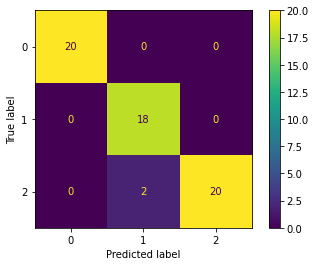

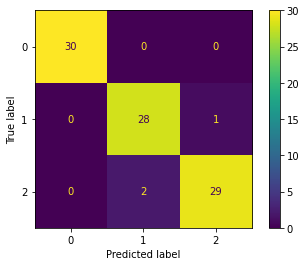

In [801]:
cm_train_display = metrics.ConfusionMatrixDisplay(confusion_matrix=ConfMatrices["training"])
cm_test_display = metrics.ConfusionMatrixDisplay(confusion_matrix=ConfMatrices["testing"])

cm_test_display.plot()
plt.show()
cm_train_display.plot()
plt.show()